In [1]:
import numpy as np

In [2]:
class Layer:
    def __init__(self, num_inputs,num_neurons, activation, learning_rate):
        self.num_neurons = num_neurons
        self.activation = activation
        self.weights = np.random.randn(num_inputs, num_neurons)
        self.biases = np.zeros((1, self.num_neurons))
        self.learning_rate = learning_rate

    def forward(self, inputs):
        self.inputs = inputs
        self.output = self.activation(np.dot(inputs, self.weights) + self.biases)
        return self.output

    def backward(self, d_output):
        d_inputs = np.dot(d_output, self.weights.T)
        d_weights = np.dot(self.inputs.T, d_output)
        d_biases = np.sum(d_output, axis=0)
        return d_inputs, d_weights, d_biases
    
    def update_weights(self, d_weights, d_biases):
        self.weights -= d_weights * self.learning_rate
        self.biases -= d_biases * self.learning_rate


In [3]:
class Network:
    def __init__(self, output_function):
        self.layers = []
        self.output_function = output_function

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, inputs):
        output = inputs
        for layer in self.layers:
            output = layer.forward(output)
        return self.output_function.forward(output)
    
    def backward(self, d_output):
        d_inputs = self.output_function.backward(d_output)
        for layer in reversed(self.layers):
            d_inputs, d_weights, d_biases = layer.backward(d_inputs)
            layer.update_weights(d_weights, d_biases)

In [4]:
# logsumexp function to avoid overflow/underflow
def logsumexp(x):
    offset = np.max(x, axis=0)
    return offset + np.log(np.sum(np.exp(x - offset), axis=0))

In [5]:
# log of sigmoid is easier to define apply the logsumexp to
def logsigma(x):
    if isinstance(x, np.ndarray):
        return -logsumexp(np.array([np.zeros(x.shape), -x]))
    return -logsumexp(np.array([0,-x]))

# activation functions
def sigmoid(x):
    return np.exp(logsigma(x))

def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

# output_functions
class Softmax():
    def forward(self, x):
        max_x = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - max_x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def backward(self, output):
        m, n = output.shape
        a = np.eye(output.shape[-1])
        diagonal = np.zeros((m, n, n),dtype=np.float32)
        off_diagonal = np.zeros((m, n, n),dtype=np.float32)
        diagonal = np.einsum('ij,jk->ijk',output,a)
        off_diagonal = np.einsum('ij,ik->ijk',output,output)
        jacobian = diagonal - off_diagonal
        return np.einsum('ijk,ik->ij', jacobian, output)
    
class Linear():
    def forward(self, x):
        return x

    def backward(self, output):
        return output


In [6]:
def load_iris():
    from sklearn.datasets import load_iris
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.model_selection import train_test_split

    # Load the iris dataset
    iris = load_iris()
    X = iris.data
    y = iris.target

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #split the train set into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # One-hot encode the target variable
    encoder = OneHotEncoder()
    y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
    return X_train, X_val, X_test, y_train, y_val, y_test, y_train_encoded

In [7]:
def initialize_network():
    network = Network(output_function=Softmax())
    network.add_layer(Layer(num_inputs=4, num_neurons=10, activation=relu,learning_rate=0.01))
    network.add_layer(Layer(num_inputs=10, num_neurons=3, activation=tanh,learning_rate=0.01))
    return network

In [8]:
def train_model(batch_size:int, num_epochs:int,dataset,network:Network, error_function):
    X_train, X_val, X_test, y_train, y_val, y_test, y_train_encoded = dataset()

    training_errors = []
    validation_errors = []

    num_samples = X_train.shape[0]
    num_batches = num_samples // batch_size

    for epoch in range(num_epochs):
        # Shuffle the training data
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_encoded[indices]

        # Split the shuffled data into mini-batches
        for batch in range(num_batches):
            start = batch * batch_size
            end = (batch + 1) * batch_size

            # Forward pass
            output = network.forward(X_train_shuffled[start:end])

            # Backward pass
            d_output = output - y_train_shuffled[start:end]
            network.backward(d_output)

        # training accuracy
        output = network.forward(X_train)
        predictions = np.argmax(output, axis=1)
        training_errors.append(error_function(y_train, predictions))
        
        # validation accuracy
        output = network.forward(X_val)
        predictions = np.argmax(output, axis=1)
        validation_errors.append(error_function(y_val, predictions))
    # test accuracy
    output = network.forward(X_test)
    predictions = np.argmax(output, axis=1)
    test_error = error_function(y_test, predictions)
    return test_error, training_errors, validation_errors

In [9]:
test_error, training_errors, validation_errors = train_model(
    batch_size=10,
    num_epochs=100,
    dataset=load_iris,
    network=initialize_network(),
    error_function=lambda y_true, y_pred: np.mean(y_true != y_pred)
)
print(f"Test error: {test_error:.4f}")

Test error: 0.6333


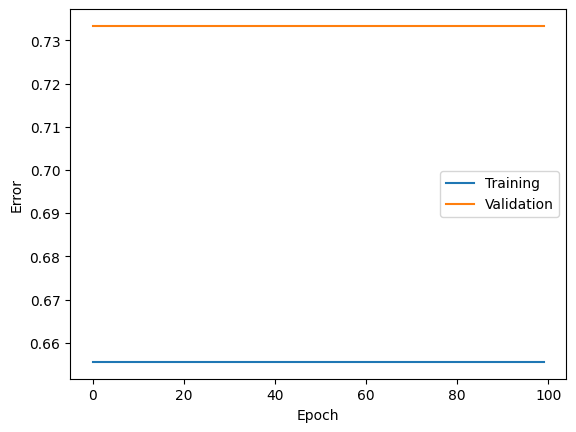

In [10]:
import matplotlib.pyplot as plt

# Plot the accuracy
plt.plot(training_errors)
plt.plot(validation_errors)
plt.xlabel('Epoch')
plt.ylabel('Error')

plt.legend(['Training', 'Validation'])
plt.show()